1. Cały kod został napisany jednego dnia, w niedzielę przed oddaniem. Przez inne zobowiązania dopiero w ostatnim tygodniu miałem czas na projekty i prawie cały ten czas poświęciłem na projekt z przetwarzania obrazów.  
2. Mimo wszystko kod przechodził wiele zmian.  
3. Najpierw skorzystałem z kodu z zajęć na sentyment, ale wyniki były niezadowalające. Potem próbowałem kilka różnych własnych opcji sieci, ale nie byłem w stanie osiągnąć wyniku, który by mi odpowiadał.  
4. Ostatecznie szukałem innej bazy niż ta wbudowana imdb na kaggle i natrafiłem na projekt tam, który miał i bazę i kod, więc skorzystałem z obu, i na tym kodzie było już ciekawie, ale jeszcze popracowałem nad parametrami, aby lekko podnieść wyniki i wydaje mi się, że osiągnąłem pewien sufit na tych danych wejściowych, bo nie byłem w stanie osiągnąć więcej niż 82% acucracy na walidacji. Jeszcze na nieszczęście model z najlepszą matrycą pomyłek przypadkiem nadpisałem innym, więc ten co został użyty jest prawie najlepszy z osiągniętych, bo potem nie udało mi się powtórzyć wyniku, ale rónica nie jest wielka.  
5. Kod na obsługę chatbota pochodzi głównie z mojej implementacji przeszłego zadania stworzenia chatbota na tych zajęciach. Mowa o kodzie wewnętrznym, przetwarzającym zapytanie i obrabiającym prompt, bo cały frontend jest świeży. Korzystałem też tutaj z nowszej wersji Qt (Qt5 vs Qt6).  
6. Podobnie jak w przypadku DNN wymagane jest kilka plików do wczytania, ale w tym przypadku są to małe pliki, nawet ten modelu zajmuje 8MB, więc najpewniej tutaj uda mi się wszystkie dołączyć do zadania na Teams. Jest też potrzebny model spacy i kilka dodatków nltk, ale te rzeczy dodałem w warunkach aplikacji, więc jeśli ich nie ma to same się pobiorą. Jest też ponownie obecny plik requirements.txt z wersjami bibliotek.
7. Zaznaczę jeszcze, skoro nie czyszczę outputu, że te wykresy po trenowaniu i output trenowania nie dotyczy w rzeczywistości tylko 8 epok, w rzeczywistości epok było 23. Po prostu na pierwszych wersjach modelu EarlyStopping włączał się po 7 epokach, a wraz z poprawkami przekraczał te ustawione 15, ale nie chciałem podnosić 15 do wyższej liczby i wykonoywałem dwa razy. A więc te 8 epok, które się wyświetlają to 8 epok z drugiego wykonania, po pierwszych 15 epokach.

In [ ]:
# Wszystkie importy do całego notatnika
import sys
import re
import string
import random
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import seaborn as sns
import spacy
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer as WNL
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW
from PyQt6.QtWidgets import (
	QApplication, QWidget, QVBoxLayout, QHBoxLayout, QPushButton, QLabel, QTextEdit, QLineEdit,
	QTabWidget, QMessageBox, QTableWidget, QTableWidgetItem, QSizePolicy
)
from PyQt6.QtGui import QTextCursor
from PyQt6.QtCore import QTimer

2025-06-02 02:51:16.155527: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 02:51:16.168567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748825476.181232  279578 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748825476.184813  279578 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-02 02:51:16.200747: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
# Komórka, w której przygotowywane są dane do treningu modelu oceniającego sentyment
# Kod jest kopią z https://www.kaggle.com/code/amustafa4983/sentiment-analysis-on-imdb-movie-reviews/notebook

df = pd.read_csv('IMDB Dataset.csv')									# Wczytanie datasetu

nltk.download('stopwords')												# Pobranie stopwords

# Funkcja usuwająca stopwords
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    words = text.split()
    filtered_sentence = ''
    for word in words:
        if word not in stop_words:
            filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

# Funkcja usuwająca znaki interpunkcyjne
def remove_punctuation(text):
    table = str.maketrans('','',string.punctuation)
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = word.translate(table)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

# Normalizacja tekstu
def normalize_text(text):
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\\W', ' ', text)
    text = re.sub('\n', '', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('^ ', '', text)
    text = re.sub(' $', '', text)
    return text

# Stemowanie tekstu
def stemming(text):
    ps = PorterStemmer()
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = ps.stem(word)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

# Funkcja czyszcząca tekst, w tym wywołująca powyższe
def clean_text(text):
    text = text.lower()
    text = text.replace(',',' , ')
    text = text.replace('.',' . ')
    text = text.replace('/',' / ')
    text = text.replace('@',' @ ')
    text = text.replace('#',' # ')
    text = text.replace('?',' ? ')
    text = normalize_text(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = stemming(text)
    return text

df['review'] = df['review'].apply(clean_text) 							# Czyszczenie tekstu

X = df["review"]
y = df['sentiment']

one = OneHotEncoder()			# Gorąca jedynka
y = one.fit_transform(np.asarray(y).reshape(-1,1)).toarray()			# Zastosowanie gorącej jedynki do etykiet

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True)


# Zapisanie gorącej jedynki jako enkodera do pliku
# Będzie wczytywane do wykorzystania w aplikacji
with open("encoder.bin", "wb") as f: 
    pickle.dump(one, f)

vocab_size = 10000		# Liczba słów w słowniku
max_length = 50			# Maksymalna długość sekwencji

trunc_type = 'post'		# Typ przycinania sekwencji
padding_type = 'post'	# Typ uzupełniania sekwencji
oov_tok = '<OOV>'		# Token dla słów spoza słownika

# Stworzenie tokenizera i dopasowanie go do danych treningowych
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

# Zapisanie konfiguracji tokenizera do pliku JSON
# Będzie wczytywane do wykorzystania w aplikacji
tok_conf = tokenizer.to_json()
with open('tok_conf.json', 'w') as outfile:
    outfile.write(json.dumps(tok_conf))
    
# Zamiana tekstów na sekwencje liczbowe
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_length,
                         padding=padding_type,
                         truncating=trunc_type)
X_test = pad_sequences(X_test, maxlen=max_length,
                         padding=padding_type,
                         truncating=trunc_type)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Budowa modelu do oceny sentymentu

def build_model():
    model = Sequential()

    model.add(Embedding(vocab_size, 64, input_length=max_length))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))

    model.add(LSTM(32, return_sequences=True))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))

    model.add(LSTM(32))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=AdamW(learning_rate=0.00001, weight_decay=0.02), metrics=['accuracy', 'mae'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    return model, early_stopping

model, early_stopping = build_model()

model.summary()

/usr/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Trenig modelu
batch_size = 250
history = model.fit(X_train,y_train,epochs=15,batch_size=batch_size,validation_split=.1,callbacks=[early_stopping])

Epoch 1/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8553 - loss: 0.3632 - mae: 0.2337 - val_accuracy: 0.8083 - val_loss: 0.4158 - val_mae: 0.2540
Epoch 2/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8556 - loss: 0.3659 - mae: 0.2340 - val_accuracy: 0.8102 - val_loss: 0.4151 - val_mae: 0.2497
Epoch 3/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8590 - loss: 0.3566 - mae: 0.2277 - val_accuracy: 0.8095 - val_loss: 0.4137 - val_mae: 0.2474
Epoch 4/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8639 - loss: 0.3490 - mae: 0.2218 - val_accuracy: 0.8133 - val_loss: 0.4141 - val_mae: 0.2444
Epoch 5/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8708 - loss: 0.3357 - mae: 0.2126 - val_accuracy: 0.8117 - val_loss: 0.4129 - val_mae: 0.2414
Epoch 6/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8697 - loss: 0.3349 - mae: 0.2114 - val_accuracy: 0.8123 - val_loss: 0.4129 - val_mae: 0.2402
Epoch 7/15
144/144 ━━━━━━━━━━━━━━━

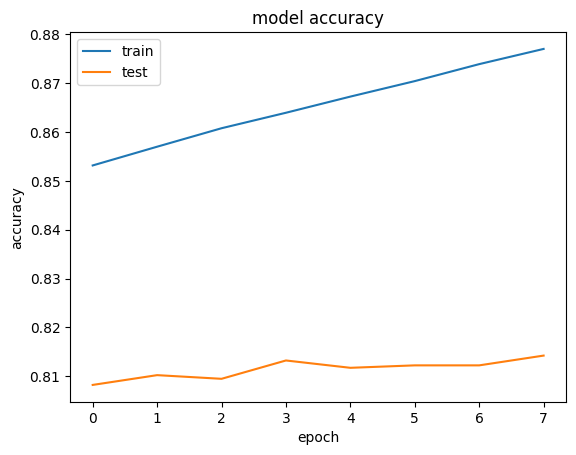

In [ ]:
# Wizualizacja wyników treningu
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')	
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Ewaluacja modelu na zbiorze testowym
score = model.evaluate(np.asarray(X_test),np.asarray(y_test))
print(f"on test split\nLoss: {round(score[0],4)}, accuracy: {round(score[1],2)*100}%, mae: {round(score[2],4)}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8085 - loss: 0.4208 - mae: 0.2563
on test split
Loss: 0.4256, accuracy: 81.0%, mae: 0.2579


In [ ]:
# Wczytywanie modelu do poniższych dwóch predykcji
model = keras.models.load_model('sentiment.keras')

In [ ]:
# Matryca pomyłek ze zbioru testowego
pred = model.predict(X_test)
pred = one.inverse_transform(pred)
test = one.inverse_transform(y_test)

matrix = confusion_matrix(test, pred, labels=["negative","positive"])
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(["negative","positive"], size=10)
ax.yaxis.set_ticklabels(["negative","positive"], size=10)
plt.savefig('confusio_matrix.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


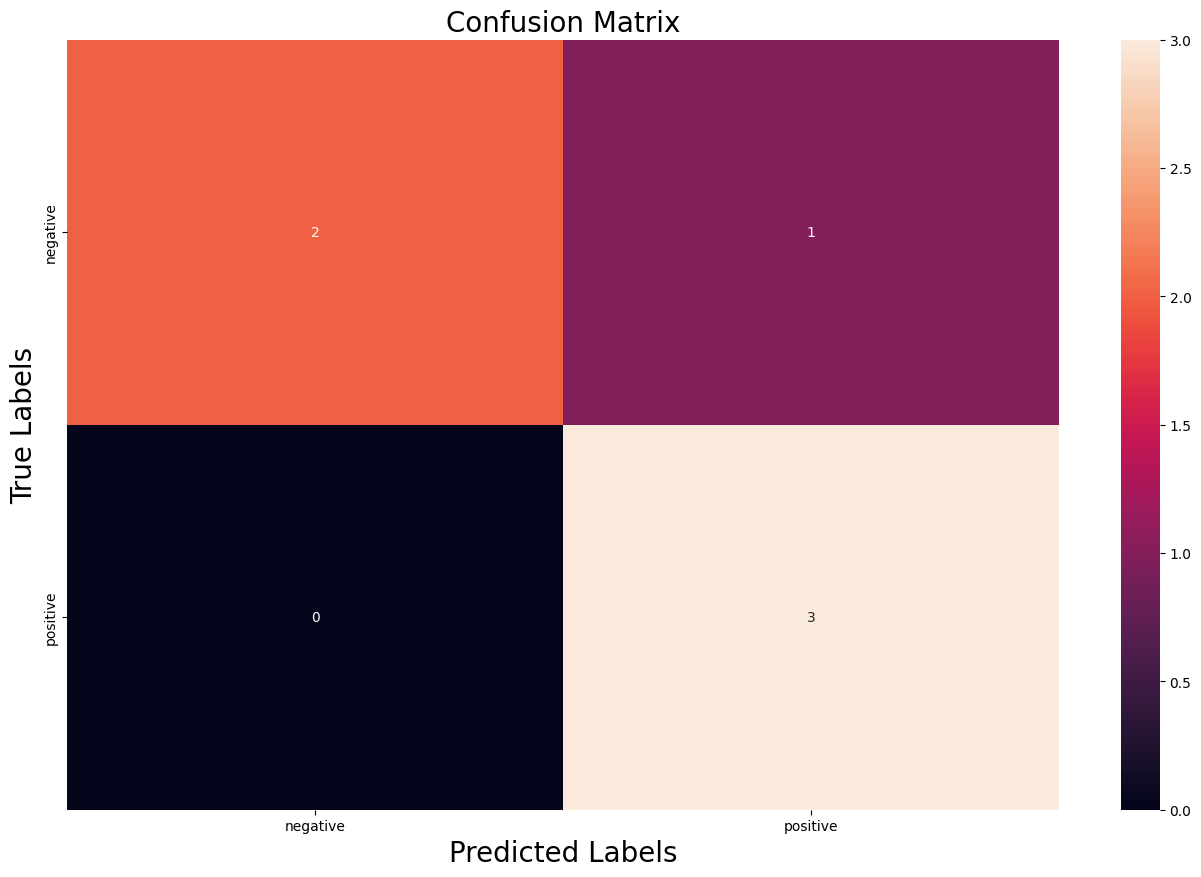

In [ ]:
# Kilka własnych recenzji do przetestowania modelu z matrycą pomyłek

input_reviews = [
    "This movie was amazing! I loved it.",
    "This movie was terrible. I hated it.",
    "The plot was okay, but the acting was great.",
    "I would not recommend this movie to anyone.",
    "This movie was the best. I loved the plot and the acting was great.",
	"This movie was the worst. I hated the plot and the acting was terrible."
]

y_reviews = ['positive', 'negative', 'positive', 'negative', 'positive', 'negative']
one = OneHotEncoder()

y_reviews = one.fit_transform(np.asarray(y_reviews).reshape(-1,1)).toarray()

for i in range(len(input_reviews)):
	input_reviews[i] = clean_text(input_reviews[i])

vocab_size = 10000
max_length = 50

trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

tokenizer_data = json.load(open('tok_conf.json', 'r'))
tokenizer = tokenizer_from_json(tokenizer_data)

input_reviews = tokenizer.texts_to_sequences(input_reviews)

input_reviews = pad_sequences(input_reviews, maxlen=max_length,
                         padding=padding_type,
                         truncating=trunc_type)

pred = model.predict(input_reviews)
pred = one.inverse_transform(pred)
test = one.inverse_transform(y_reviews)


matrix = confusion_matrix(test, pred, labels=["negative","positive"])
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(["negative","positive"], size=10)
ax.yaxis.set_ticklabels(["negative","positive"], size=10)
plt.savefig('confusio_matrix.png')

In [ ]:
# Zapis modelu do pliku
model.save('sentiment.keras')

In [ ]:
# Funkcje pomocnicze, obecne już na początku, ale tutaj skopiowałem dla osobnego wykonania dla aplikacji
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    words = text.split()
    filtered_sentence = ''
    for word in words:
        if word not in stop_words:
            filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

# Remove Punvtuation
def remove_punctuation(text):
    table = str.maketrans('','',string.punctuation)
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = word.translate(table)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

# Normalize Text
def normalize_text(text):
    text = text.lower()
    # get rid of urls
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # get rid of non words and extra spaces
    text = re.sub('\\W', ' ', text)
    text = re.sub('\n', '', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('^ ', '', text)
    text = re.sub(' $', '', text)
    return text

def stemming(text):
    ps = PorterStemmer()
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = ps.stem(word)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

def clean_text(text):
    text = text.lower()
    text = text.replace(',',' , ')
    text = text.replace('.',' . ')
    text = text.replace('/',' / ')
    text = text.replace('@',' @ ')
    text = text.replace('#',' # ')
    text = text.replace('?',' ? ')
    text = normalize_text(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = stemming(text)
    return text

In [ ]:
# Główny kod projektu, klasa aplikacji z wywołaniem

class nlpApp(QWidget):
	def __init__(self):
		super().__init__()
		self.windowTitle = "NLP Analysis App"
		main_layout = QHBoxLayout()

		# Stworzenie dwóch zakładek
		self.tabs = QTabWidget()
		self.init_tab1()
		self.init_tab2()
		main_layout.addWidget(self.tabs)
		self.setLayout(main_layout)

		# Stworzenie zmiennych na modele, inicjalizacja jednego
		self.sentimentModel = None
		self.oneEncoder = None
		self.tokenizer = None
		self.nlp = None
		self.stemmer = None
		self.diLemma = WNL()

	# Funkcja do predykcji sentymentu
	def get_sentiment(self, text):
		# Jeśli model i elementy nie są załądowane, to są ładowane
		if self.sentimentModel is None:
			try:
				self.sentimentModel = keras.models.load_model('sentiment.keras')
				self.oneEncoder = pickle.load(open("encoder.bin", "rb"))
				tokenizer_config = json.load(open('tok_conf.json', 'r'))
				self.tokenizer = tokenizer_from_json(tokenizer_config)
			except Exception as e:
				QMessageBox.critical(self, "Error", f"Failed to load sentiment model: {str(e)}")
				return str(e)
		
		input = clean_text(text)	# Czyszczenie tekstu

		input = self.tokenizer.texts_to_sequences([input])	# Zamiana tekstu na sekwencje liczbowe

		input = pad_sequences(input, maxlen=50,
			                         padding="post",
			                         truncating="post")		# Uzupełnianie sekwencji do maksymalnej długości

		pred = self.sentimentModel.predict(input)			# Predykcja sentymentu
		pred = self.oneEncoder.inverse_transform(pred)		# Odwrócenie gorącej jedynki, aby uzyskać etykiety
		return pred[0][0] if pred else "Error"				# Jeśli nie ma predykcji, zwróć błąd
	
	# Funkcja do stemowania i lematyzacji tekstu
	def get_stelem(self, text):
		# Jeśli model i elementy nie są pobrane, to są pobierane
		try:
			spacy.load("en_core_web_md")
		except OSError:
			spacy.cli.download("en_core_web_md")

		for resource in ['averaged_perceptron_tagger', 'wordnet', 'stopwords']:
			try:
				nltk.data.find(f'taggers/{resource}' if resource == 'averaged_perceptron_tagger' else f'corpora/{resource}')
			except LookupError:
				nltk.download(resource, quiet=True)

		# Jeśli nlp nie jest załadowane to jest ładowane
		if self.nlp is None:
			try:
				self.nlp = spacy.load("en_core_web_md")
				self.stemmer = PorterStemmer()
			except Exception as e:
				QMessageBox.critical(self, "Error", f"Failed to load NLP model: {str(e)}")
				return str(e)
			
		doc = self.nlp(text)		# Przetwarzanie dokumentu
		results = []

		for token in doc:			# Iteracja po tokenach w dokumencie
			if token.is_alpha and not token.is_stop:			# Sprawdzenie, czy token jest alfanumeryczny i nie jest stopwordem
				lemma = token.lemma_.lower()					# Lemat tokena
				stem = self.stemmer.stem(token.text.lower())	# Stemming tokena
				results.append((token.text, lemma, stem))
		return results

	# Definicja zakładki narzędziowej
	def init_tab1(self):
		widget = QWidget()
		layout = QVBoxLayout()
		layout.setSpacing(6)

		# Element wprowadzania tekstu
		inputLabel = QLabel("Input Text:")
		self.inputText = QLineEdit()
		self.inputText.setPlaceholderText("Enter text for processing...")
		self.inputText.setClearButtonEnabled(True)
		layout.addWidget(inputLabel)
		layout.addWidget(self.inputText)

		buttonsRow = QHBoxLayout()
		buttonsRow.setSpacing(2)

		# Przycisk do analizy sentymentu
		sentimentBtn = QPushButton("Analyze Sentiment")
		sentimentBtn.clicked.connect(self.sentimentBtn_clicked)
		buttonsRow.addWidget(sentimentBtn)

		# Przycisk do stemowania i lematyzacji
		stemlemBtn = QPushButton("Stem && Lemmatize")
		stemlemBtn.clicked.connect(self.stemlemBtn_clicked)
		buttonsRow.addWidget(stemlemBtn)

		layout.addLayout(buttonsRow)

		# Pole wyników
		self.resultLabel = QLabel("Result: ")
		self.resultLabel.setWordWrap(True)
		layout.addWidget(self.resultLabel)

		# Tabela wyników dla stemowania i lematyzacji
		self.resultTable = QTableWidget()
		self.resultTable.setColumnCount(3)
		self.resultTable.setHorizontalHeaderLabels(["Token", "Lemma", "Stem"])
		self.resultTable.setSizePolicy(QSizePolicy.Policy.Fixed, QSizePolicy.Policy.Fixed)
		self.resultTable.horizontalHeader().setStretchLastSection(False)
		self.resultTable.hide()
		layout.addWidget(self.resultTable)

		layout.addStretch()
		widget.setLayout(layout)
		self.tabs.addTab(widget, "Tools")

	# Funkcja obsługi przycisku analizy sentymentu
	def sentimentBtn_clicked(self):
		self.resultTable.hide()
		text = self.inputText.text().strip()
		if not text:
			return
		
		response = self.get_sentiment(text)
		self.resultLabel.setText(f"Result: {response}")
		self.inputText.clear()

	# Funkcja obsługi przycisku stemowania i lematyzacji
	def stemlemBtn_clicked(self):
		text = self.inputText.text().strip()
		response = self.get_stelem(text)

		# Tworzenie tabelki z odpowiedzi
		self.resultTable.setRowCount(len(response))
		self.resultLabel.setText("Result:")
		for row, (token, lemma, stem) in enumerate(response):
			self.resultTable.setItem(row, 0, QTableWidgetItem(token))
			self.resultTable.setItem(row, 1, QTableWidgetItem(lemma))
			self.resultTable.setItem(row, 2, QTableWidgetItem(stem))
			
		self.resultTable.show()
		QTimer.singleShot(0, self.adjustTableToContents)
		self.inputText.clear()

	# Specjalna funkcja do dostosowania tabeli do zawartości
	def adjustTableToContents(self):
		self.resultTable.resizeColumnsToContents()
		self.resultTable.resizeRowsToContents()

		header_width = self.resultTable.verticalHeader().width()
		frame_w = self.resultTable.frameWidth() * 2
		columns_width = 0
		for col in range(self.resultTable.columnCount()):
			columns_width += self.resultTable.columnWidth(col)
		total_width = header_width + columns_width + frame_w

		header_height = self.resultTable.horizontalHeader().height()
		frame_h = self.resultTable.frameWidth() * 2
		rows_height = 0
		for row in range(self.resultTable.rowCount()):
			rows_height += self.resultTable.rowHeight(row)
		total_height = header_height + rows_height + frame_h

		self.resultTable.setFixedSize(total_width, total_height)

	# Definicja zakładki czatu
	def init_tab2(self):
		widget = QWidget()
		layout = QVBoxLayout()
		layout.setSpacing(6)

		# Historia czatu
		self.chatHistory = QTextEdit()
		self.chatHistory.setReadOnly(True)
		self.chatHistory.setStyleSheet("""
QTextEdit {
    background-color: #f0f0f0;
}
QScrollBar:vertical {
    background: #f0f0f0;
    width: 12px;
    margin: 0;
    border-radius: 6px;
}
QScrollBar::handle:vertical {
    background: #6c8cd5;
    min-height: 30px;
    border-radius: 6px;
}
QScrollBar::handle:vertical:hover {
    background: #3a5bbb;
}
QScrollBar::sub-line:vertical, QScrollBar::add-line:vertical {
    height: 0px;
}
QScrollBar::add-page:vertical, QScrollBar::sub-page:vertical {
    background: none;
}
""")
		layout.addWidget(self.chatHistory)

		# Pole wprowadzania tekstu
		input_layout = QHBoxLayout()
		self.chatInput = QLineEdit()
		self.chatInput.returnPressed.connect(self.send_prompt)
		self.chatInput.setPlaceholderText("Type your prompt here...")

		# Przycisk wysyłania zapytania
		sendBtn = QPushButton("Send")
		sendBtn.clicked.connect(self.send_prompt)

		input_layout.addWidget(self.chatInput)
		input_layout.addWidget(sendBtn)

		layout.addLayout(input_layout)
		widget.setLayout(layout)
		self.tabs.addTab(widget, "Chat")

	# Funkcja obsługi wysyłania zapytania
	def send_prompt(self):
		prompt = self.chatInput.text().strip()
		if not prompt:
			return
		
		# Użytkownik wysyła zapytanie
		self.appendChatHistory("You", prompt)

		# Bot odpowiada
		response = self.get_response(prompt)
		self.appendChatHistory("Bot", response)

		self.chatInput.clear()

	# Funkcja dopisywania do historii czatu
	def appendChatHistory(self, sender, message):
		color = "#007acc" if sender == "You" else "#444444"
		msgFormat = f'<b><span style="color:{color}">{sender}</span></b> {message}<br>'
		self.chatHistory.moveCursor(QTextCursor.MoveOperation.End)
		self.chatHistory.insertHtml(msgFormat)
		self.chatHistory.moveCursor(QTextCursor.MoveOperation.End)
		self.chatHistory.verticalScrollBar().setValue(self.chatHistory.verticalScrollBar().maximum())
	
	# Funkcja walidacji zapytania
	def get_response(self, prompt):
		
		# Jeśli nie podano tekstu do przetworzenia
		if '"' not in prompt:
			desc = prompt.strip()
			text = ""
			return "You did not add text to process in quotations. Correct format is 'Action description \"Text\"'."

		# Jeśli podano tylko jeden cudzysłów (zły format)
		if prompt.count('"') == 1:
			desc = prompt.replace('"', '').strip()
			text = ""
			return "You used only one quotation mark. Correct format is 'Action description \"Text\"'."

		pattern = re.compile(r'^(.*?)"([\s\S]*?)"(.*)$')		# Wyrażenie regularne wyszukujące tekst w cudzysłowiu

		match = pattern.match(prompt)							# Zastosowanie wyrażenia regularnego

		desc = match.group(1).strip()							# Wyciągnięcie opisu działania
		text = match.group(2)									# Wyciągnięcie tekstu do przetworzenia

		if desc == "":
			return "You did not provide an action description. Correct format is 'Action description \"Text\"'."
		
		if text == "":
			return "Text in quotations is empty. Correct format is 'Action description \"Text\"'."
		
		response = self.ask(desc, text)		# Wysłanie zapytania do funkcji ask
		return response
	
	# Funkcja przetwarzania zapytań i zwracania odpowiedzi
	def ask(self, desc, text):

		# Lista słów kluczowych i ich typów odpowiedzi, 0 - analiza sentymentu, 1 - stemowanie i lematyzacja
		dialog = [
			("lemmatize", 1),
			("stem", 1),
			("process", 1),
			("sentiment", 0),
			("analyze", 0),
			("token", 1),
			("tokenize", 1),
			("lemma", 1),
			("stemming", 1),
			("stemmer", 1),
			("analyse", 0),
			("sent", 1),
			("attitude", 0),
			("emotion", 0),
			("feel", 0),
			("opinion", 0),
			("review", 0),
			("position", 0),
			("thought", 0),
			("view", 0),
			("perspective", 0),
			("stance", 0),
			("standpoint", 0),
			("decomposition", 1),
			("decay", 1),
			("breakdown", 1),
			("dissection", 1),
			("dissect", 1),
			("riddle", 0), 
			("describe", 0),
			("analyser", 0),
			("analyzer", 0),
			("analyzing", 0),
			("analysis", 0),
			("examine", 0),
			("examiner", 0),
			("examining", 0),
			("examination", 0),
			("mood", 0),
			("emotionally", 0),
			("positivity", 0),
			("negativity", 0),
			("positive", 0),
			("negative", 0),
			("tone", 0),
			("affective", 0),
			("sentimentally", 0),
			("reaction", 0),
			("vibe", 0),
			("judgment", 0),
			("critique", 0),
			("rating", 0),
			("feedback", 0),
			("appraisal", 0),
			("reception", 0),
			("evaluate", 0),
			("estimation", 0),
			("estimate", 0),
			("appreciation", 0),
			("response", 0),
			("emotive", 0),
			("normalize", 1),
			("normalise", 1),
			("simplify", 1),
			("base form", 1),
			("inflection", 1),
			("preprocess", 1),
			("clean", 1),
			("cleanse", 1),
			("format", 1),
			("deconstruct", 1),
			("processing", 1),
			("clean text", 1),
			("parser", 1),
			("parse", 1),
			("break into words", 1),
			("structure", 1),
			("text flow", 1),
			("syntactic", 1),
			("grammar", 1),
			("text form", 1),
			("phrase breakdown", 1),
		]
		
		# Funkcja do uzyskania części mowy dla lematyzacji
		def get_wordnet_pos(tag):
			if tag.startswith('J'):
				return wordnet.ADJ
			elif tag.startswith('V'):
				return wordnet.VERB
			elif tag.startswith('N'):
				return wordnet.NOUN
			elif tag.startswith('R'):
				return wordnet.ADV
			else:
				return None
		
		# Funkcja do podziału i czyszczenia zdania
		def split_and_clean(sentence):
			tokenized = word_tokenize(sentence.lower())
			tagged = pos_tag(tokenized)
			lemmatized = []

			for word, tag in tagged:
				if word.isalpha():
					pos = get_wordnet_pos(tag) or wordnet.NOUN
					lemmatized.append(self.diLemma.lemmatize(word, pos=pos))

			return lemmatized
		
		# Funkcja do znalezienia najlepszego dopasowania typu działania do opisu działania
		def find_matching(input_prompt):
			answer = None
			intersection_len_req = 0
			input_prompt = set(split_and_clean(input_prompt))
			for index, pair in enumerate(dialog):
				match = set(split_and_clean(pair[0]))
				intersection_len = len(set.intersection(input_prompt, match))
				if intersection_len > intersection_len_req:
					answer = index
					intersection_len_req = intersection_len
				if intersection_len == intersection_len_req and intersection_len != 0:
					if random.randint(0, 1) == 1:
						answer = index

			if answer is not None:
				answer = dialog[answer][1]
			return answer
		
		response_type = find_matching(desc)		# Wyszukanie najlepszego dopasowania typu działania do opisu działania

		# Jeśli nie znaleziono dopasowania, zwróć brak możliwego działania
		if response_type is None:
			return "I don\'t know how to answer that."
		
		# Obsługa działania analizy sentymentu
		if response_type == 0 or response_type == "0":
			try:
				response = self.get_sentiment(text)
				response = f"The sentiment of the text is: {response}"
			except Exception:
				response = None

		# Obsługa działania stemowania i lematyzacji
		if response_type == 1 or response_type == "1":
			try:
				response = self.get_stelem(text)
				
				# Tworzenie tabelki
				table_html = """
				The stemmed & lemmatized text is:<br>
				<table style="
					border-collapse: collapse; 
					margin-top: 6px; 
					font-family: Arial, sans-serif;
					background-color: #ffffff;
				">
				<thead>
				<tr style="
					background-color: #e0e0e0; 
					font-weight: bold;
					border-bottom: 2px solid #888;">
					<th style='padding: 6px; border: 1px solid #ccc;'>Token</th>
					<th style='padding: 6px; border: 1px solid #ccc;'>Lemma</th>
					<th style='padding: 6px; border: 1px solid #ccc;'>Stem</th>
				</tr>
				</thead>
				<tbody>
				"""
				for token, lemma, stem in response:
					table_html += f"""
				<tr>
					<td style='padding: 6px; border: 1px solid #ccc;'>{token}</td>
					<td style='padding: 6px; border: 1px solid #ccc;'>{lemma}</td>
					<td style='padding: 6px; border: 1px solid #ccc;'>{stem}</td>
				</tr>"""
				
				table_html += "</tbody></table><br>"
				
				response = table_html
			except Exception:
				response = None
		
		# Zwrot odpowiedzi lub informacja o błędzie
		return response if response else "Something went wrong while processing your request."

# Uruchomienie aplikacji
if __name__ == "__main__":
	app = QApplication(sys.argv)
	window = nlpApp()
	window.resize(1000, 600)
	window.show()
	sys.exit(app.exec())